# 1. Import libraries

In [122]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import nltk
import seaborn as sns
import re
import matplotlib.pyplot as plt
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 2. Read and clean data

In [123]:
df=pd.read_csv('../input/emotions-in-text/Emotion_final.csv') #Text data
EMBEDDING_FILE= f'../input/glove6b300dtxt/glove.6B.300d.txt' #GloVe file path
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Emotion', ylabel='count'>

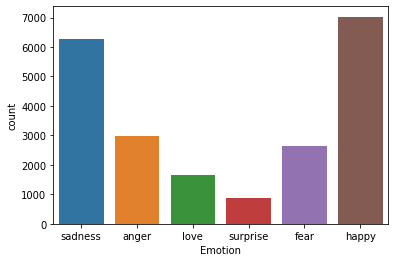

In [124]:
#Target Classes
sns.countplot(df['Emotion']) 

In [125]:
df=df.dropna() #Drop columns with NA values
X=df.drop('Emotion',axis=1) #Input
y=df['Emotion'] #Output

In [126]:
messages=X.copy()
messages.reset_index(inplace=True) #Drop NA may cause inconsistency in index

In [127]:
nltk.download('stopwords')
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['Text'][i]) #Remove Special Characters
    review = review.lower() #Lower case 
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')] #Remove stopwords
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [128]:
corpus[:10]

['didnt feel humili',
 'go feel hopeless damn hope around someon care awak',
 'im grab minut post feel greedi wrong',
 'ever feel nostalg fireplac know still properti',
 'feel grouchi',
 'ive feel littl burden late wasnt sure',
 'ive take milligram time recommend amount ive fallen asleep lot faster also feel like funni',
 'feel confus life teenag jade year old man',
 'petrona year feel petrona perform well made huge profit',
 'feel romant']

# 3. Embedding layer using GloVe 

In [129]:
#Creating the dictionary with word as key and pretrained-value array as value
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

#Calculate mean and std for the pretrained weights
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
print(emb_mean,emb_std)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


-0.0039050116 0.38177028


In [130]:
voc_size=13000 # Vocabulary size
embed_size=300 #word vector size

tokenizer = Tokenizer(num_words=voc_size)
tokenizer.fit_on_texts(list(corpus))
word_index = tokenizer.word_index #Total words in the corpus
nb_words = min(voc_size, len(word_index))

#Initialize weight matrix for embedding layer
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size)) 

for word, i in word_index.items():
    if i >= voc_size: continue #Skip the words if vocab size is reached
    embedding_vector = embeddings_index.get(word) #Extract the pretrained values from GloVe
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [131]:
#Contains the pretrained GloVe weights for the words
len(embedding_matrix)

13000

# 4. Process Input-Output data

In [132]:
#One hot representation for input
onehot_repr=[one_hot(words,voc_size)for words in corpus]

#Finding max words
l = 0
for x in corpus:
    l = max(l,len(x.split(' ')))

#Padding the sequences for input
sent_length= l
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[    0     0     0 ... 12182  5135  2789]
 [    0     0     0 ...   115  1314   155]
 [    0     0     0 ...  5135 11027  8631]
 ...
 [    0     0     0 ...  2047 12503  2276]
 [    0     0     0 ...  6322  2276  1816]
 [    0     0     0 ...     0  2276 12612]]


In [133]:
#Encoding the target outputs to integers
label_encoder = preprocessing.LabelEncoder()

X_final=np.array(embedded_docs) #input to array
y = label_encoder.fit_transform(y)
y_final=np.array(y)
print(y_final)

[4 4 0 ... 1 1 1]


In [134]:
X_final.shape,y_final.shape

((21459, 35), (21459,))

In [135]:
#Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, 
                                                    test_size=0.2, random_state=42) 
#Train-Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.1, random_state=21) 

# 5. Create and train model

In [136]:
# Creating model
model=Sequential()
model.add(Embedding(voc_size, embed_size, weights=[embedding_matrix]))
model.add(LSTM(64))
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01))) #L1 regularization
model.add(Dropout(0.25))
model.add(Dense(6,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 300)         3900000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 390       
Total params: 3,997,990
Trainable params: 3,997,990
Non-trainable params: 0
_________________________________________________________________


In [137]:
model_save = ModelCheckpoint('weights.h5', save_best_only = True, save_weights_only = True, monitor = 'val_accuracy', 
                             mode = 'max', verbose = 1)
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=30,batch_size=64,callbacks = [model_save, early_stopping])

Epoch 1/30
242/242 [==============================] - 11s 40ms/step - loss: 4.2310 - accuracy: 0.3501 - val_loss: 1.3613 - val_accuracy: 0.5754

Epoch 00001: val_accuracy improved from -inf to 0.57542, saving model to weights.h5
Epoch 2/30
242/242 [==============================] - 9s 38ms/step - loss: 1.1670 - accuracy: 0.6557 - val_loss: 0.9085 - val_accuracy: 0.7659

Epoch 00002: val_accuracy improved from 0.57542 to 0.76587, saving model to weights.h5
Epoch 3/30
242/242 [==============================] - 10s 40ms/step - loss: 0.7310 - accuracy: 0.8257 - val_loss: 0.7121 - val_accuracy: 0.8229

Epoch 00003: val_accuracy improved from 0.76587 to 0.82295, saving model to weights.h5
Epoch 4/30
242/242 [==============================] - 9s 38ms/step - loss: 0.5242 - accuracy: 0.8927 - val_loss: 0.6464 - val_accuracy: 0.8422

Epoch 00004: val_accuracy improved from 0.82295 to 0.84217, saving model to weights.h5
Epoch 5/30
242/242 [==============================] - 9s 39ms/step - loss: 0.

# 6. Analysis and visualization of output

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


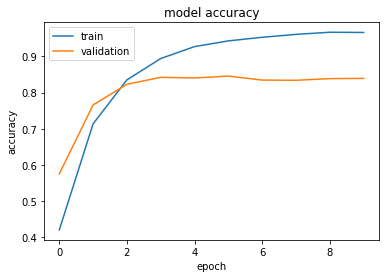

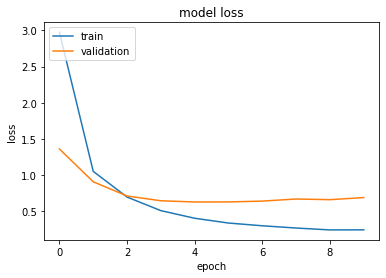

In [138]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [139]:
#Load the best weights
model.load_weights('weights.h5')

In [140]:
y_pred=model.predict_classes(X_test)
print(y_pred)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[2 0 3 ... 0 0 2]


In [141]:
#Accuracy score
print(accuracy_score(y_test,y_pred))

0.8632339235787512


In [142]:
model.evaluate(X_test, y_test)

135/135 [==============================] - 0s 3ms/step - loss: 0.5872 - accuracy: 0.8632


[0.5871975421905518, 0.8632339239120483]

In [143]:
#Classification report
print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.84615   0.85575   0.85093       617
           1    0.81835   0.82298   0.82066       531
           2    0.87858   0.91166   0.89481      1381
           3    0.75445   0.66667   0.70785       318
           4    0.92886   0.89977   0.91408      1277
           5    0.65574   0.71429   0.68376       168

    accuracy                        0.86323      4292
   macro avg    0.81369   0.81185   0.81201      4292
weighted avg    0.86351   0.86323   0.86295      4292



Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)


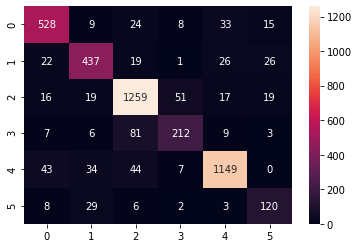

In [144]:
#Confusion Matrix
print('Confusion Matrix')
print(sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt="d"))

# 7. Test on own

In [145]:
#Mapping of target classes using label-encoder
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)

{'anger': 0, 'fear': 1, 'happy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}


In [146]:
#Example
def predict_emotion(stri):
    review = re.sub('[^a-zA-Z]', ' ', stri)
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    onehot_repr = [one_hot(review,voc_size)] 
    embed = pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
    predicti = model.predict(embed)
    return label_encoder.classes_[np.argmax(predicti)]

In [147]:
predict_emotion('I am very happy and joyful today')

'happy'

In [148]:
predict_emotion('He is an arrogant and rude person')

'anger'

In [149]:
predict_emotion('The teacher is intimidating and scary')

'fear'

In [150]:
predict_emotion('Today is very hot')

'fear'